## Download Data

In [1]:
# !wget --no-check-certificate \
#   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#   -O cats_and_dogs_filtered.zip
# ! unzip cats_and_dogs_filtered.zip

## System setting and import packages

In [2]:
import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

os.environ["RUNFILES_DIR"] = "/Users/bunnykitty/opt/anaconda3/envs/tf/share/plaidml"
# plaidml might exist in different location. Look for "/usr/local/share/plaidml" and replace in above path

os.environ["PLAIDML_NATIVE_PATH"] = "/Users/bunnykitty/opt/anaconda3/envs/tf/lib/libplaidml.dylib"
# libplaidml.dylib might exist in different location. Look for "/usr/local/lib/libplaidml.dylib" and replace in above path

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, AveragePooling2D,GlobalAveragePooling2D, Flatten
from keras.layers import Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import optimizers

import numpy as np

Using plaidml.keras.backend backend.


## Vectorize the data

In [3]:
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

ROWS = 224
COLS = 224

trdata = ImageDataGenerator(preprocessing_function=preprocess_input)
traindata = trdata.flow_from_directory(directory="cats_and_dogs_filtered/train", 
                                       target_size=(ROWS,COLS),
                                       batch_size=10)

tsdata = ImageDataGenerator(preprocessing_function=preprocess_input)
testdata = tsdata.flow_from_directory(directory="cats_and_dogs_filtered/validation", 
                                      target_size=(ROWS,COLS),
                                      batch_size=10)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Setup inceptionV3 model

In [4]:

# from tensorflow.keras.applications import InceptionV3
# inceptionv3_model = InceptionV3(weights='imagenet', 
#                                 include_top=False, input_shape=(224, 224, 3))


from keras import applications
base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(ROWS, COLS,3))
base_model.trainable = False
   
base_model.summary()


INFO:plaidml:Opening device "metal_amd_radeon_pro_5500m.0"


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [5]:
# resnet_model.trainable = True
# set_trainable = False
# # for layer in resnet_model.layers:
# #     print(layer.name)
# for layer in resnet_model.layers:
#     if layer.name in ['conv5_block3_2_conv', 'conv5_block3_3_conv', 'conv5_block3_2_relu', 'conv5_block2_out']:
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False
# resnet_model.summary()


In [6]:
# import pandas as pd
# layers_property = [(layer, layer.name, layer.trainable) for layer in resnet_model.layers]
# layers_df=pd.DataFrame(layers_property, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])
# pd.set_option("max_rows", None)
# layers_df

In [7]:
# from keras.applications.resnet152 import ResNet152

# model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=2)

# model.summary()

In [8]:
# from keras.models import Sequential
# add_model = Sequential()
# add_model.add(base_model)
# add_model.add(GlobalAveragePooling2D())
# add_model.add(Dropout(0.5))
# add_model.add(Dense(2, 
#                     activation='softmax'))

# model = add_model
# model.compile(loss='categorical_crossentropy', 
#               optimizer=optimizers.SGD(lr=1e-4, 
#                                        momentum=0.9),
#               metrics=['accuracy'])
# model.summary()


In [9]:
from keras.layers import BatchNormalization
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
# model.add(MaxPool2D())
model.add(Dense(512, activation='relu'))
# model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_95 (Batc (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 22,854,946
Trainable params: 1,051,138
Non-trainable params: 21,803,808
_________________________________________________________________


## Visualize the model

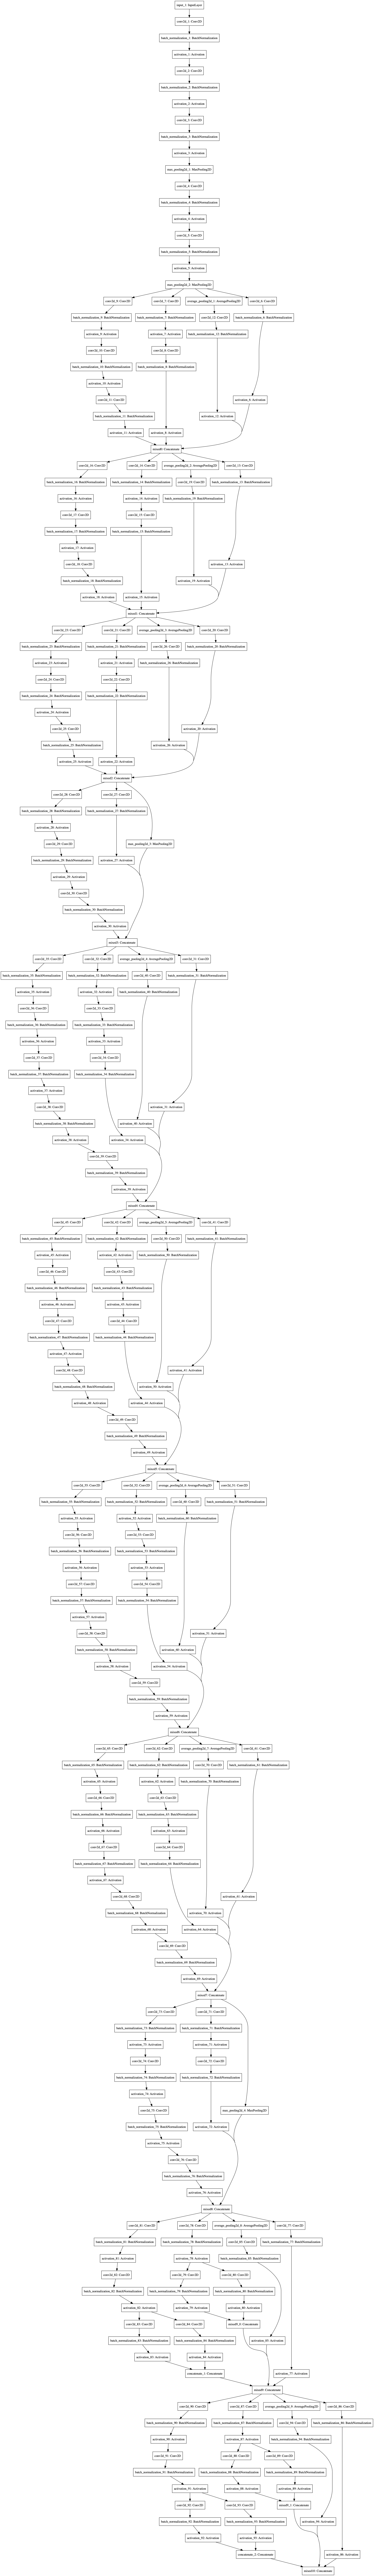

In [11]:
# from keras.utils import plot_model
from tensorflow.keras.utils import plot_model
plot_model(base_model, to_file='inceptionv3.png')

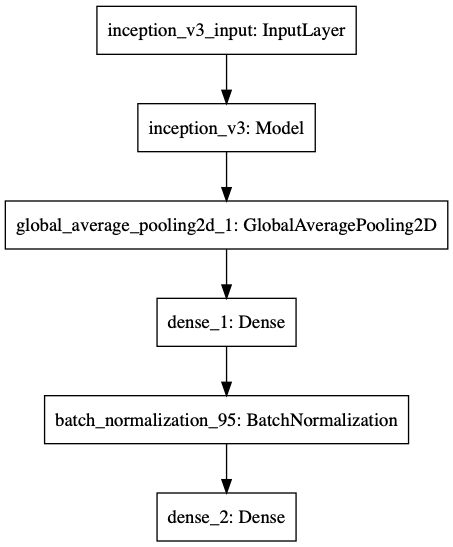

In [12]:
plot_model(model, to_file='inceptionv3_model_customized.png')

## ModelCheckpoint and EarlyStopping

In [ ]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=40, verbose=1, mode='auto')
# model_final.fit_generator(generator= traindata, steps_per_epoch= 2, epochs= 100, validation_data= testdata, validation_steps=1, callbacks=[checkpoint,early])
# model_final.save_weights("vgg16_1.h5")

In [13]:

# opt = Adam(lr=0.001)
opt=optimizers.SGD(lr=0.0001, momentum=0.9)
# opt=optimizers.RMSprop(lr=2e-5)

    

model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=["accuracy"])


In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
# filepath="vgg16_{epoch:02d}-{val_acc:.2f}.hdf5"
model_filepath="saved_model/inceptionv3_model.h5"
checkpoint = ModelCheckpoint(model_filepath, 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)
early = EarlyStopping(monitor='val_acc', 
                      min_delta=0, 
                      patience=20, 
                      verbose=1, 
                      mode='auto')
hist = model.fit_generator(steps_per_epoch=20,
                           generator=traindata, 
                           validation_data= testdata, 
                           validation_steps=10,
                           epochs=100,
                           callbacks=[checkpoint,early])
model.save_weights("saved_model/inceptionv3_model_weights.h5")
model.save(model_filepath)

Epoch 1/100


INFO:plaidml:Analyzing Ops: 1853 of 2063 operations complete


20/20 [==============================] - 21s 1s/step - loss: 0.8547 - acc: 0.5850 - val_loss: 0.7643 - val_acc: 0.5500

Epoch 00001: val_acc improved from -inf to 0.55000, saving model to saved_model/inceptionv3_model.h5
Epoch 2/100
20/20 [==============================] - 5s 229ms/step - loss: 0.7597 - acc: 0.6350 - val_loss: 0.4896 - val_acc: 0.7800

Epoch 00002: val_acc improved from 0.55000 to 0.78000, saving model to saved_model/inceptionv3_model.h5
Epoch 3/100
20/20 [==============================] - 5s 228ms/step - loss: 0.5025 - acc: 0.7650 - val_loss: 0.3604 - val_acc: 0.8900

Epoch 00003: val_acc improved from 0.78000 to 0.89000, saving model to saved_model/inceptionv3_model.h5
Epoch 4/100
20/20 [==============================] - 5s 228ms/step - loss: 0.5050 - acc: 0.7300 - val_loss: 0.3417 - val_acc: 0.8800

Epoch 00004: val_acc did not improve from 0.89000
Epoch 5/100
20/20 [==============================] - 5s 228ms/step - loss: 0.4167 - acc: 0.8050 - val_loss: 0.2663 - va

20/20 [==============================] - 5s 228ms/step - loss: 0.2332 - acc: 0.9100 - val_loss: 0.1830 - val_acc: 0.9300

Epoch 00043: val_acc did not improve from 1.00000
Epoch 44/100
20/20 [==============================] - 5s 228ms/step - loss: 0.2304 - acc: 0.8900 - val_loss: 0.1006 - val_acc: 0.9800

Epoch 00044: val_acc did not improve from 1.00000
Epoch 45/100
20/20 [==============================] - 5s 228ms/step - loss: 0.2534 - acc: 0.8750 - val_loss: 0.0693 - val_acc: 0.9700

Epoch 00045: val_acc did not improve from 1.00000
Epoch 46/100
20/20 [==============================] - 5s 228ms/step - loss: 0.1761 - acc: 0.9400 - val_loss: 0.0215 - val_acc: 0.9900

Epoch 00046: val_acc did not improve from 1.00000
Epoch 47/100
20/20 [==============================] - 5s 228ms/step - loss: 0.1558 - acc: 0.9350 - val_loss: 0.1313 - val_acc: 0.9700

Epoch 00047: val_acc did not improve from 1.00000
Epoch 00047: early stopping


## visualize

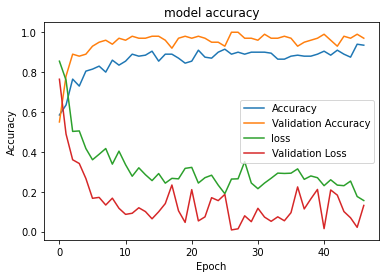

In [16]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## Validate the trained model

In [18]:
from keras.preprocessing import image
from keras.models import load_model
saved_model = load_model(model_filepath)
print(model_filepath)

saved_model/inceptionv3_model.h5


cat


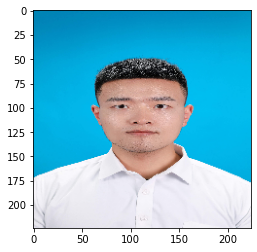

In [21]:
testimgpath="cats_and_dogs_filtered/validation/cats/cat.2001.jpg"
testimgpath="testimg/image1.jpeg"
testimgpath="testimg/ll.jpeg"
img = image.load_img(testimgpath,target_size=(224,224))
img = np.asarray(img)
import matplotlib.pyplot as plt
plt.imshow(img)
img = np.expand_dims(img, axis=0)

output = saved_model.predict(img)

if output[0][0] > output[0][1]:
    print("cat")
else:
    print('dog')